<a href="https://colab.research.google.com/github/Phrmth/New/blob/master/Submission_of_Twitter_Airline_ULMFiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Packages

In [0]:
from fastai import *
from fastai.text import *
from pathlib import Path
import pandas as pd
import numpy as np
import re
import os
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from sklearn.metrics import accuracy_score

# Cleaning the text reviews


In [0]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)


import re
regex = r"@(VirginAmerica|united|SouthwestAir|Delta|USAirways|AmericanAir|JetBlue)"
def text_replace(s):
    return re.sub(regex, '@airline', s, flags=re.IGNORECASE)

# Loading and exploring the data 

In [89]:
#Unzipping the files
!unzip Tweets.csv.zip -d /data
!ls /data
train_orig = pd.read_csv('/data/Tweets.csv')

Archive:  Tweets.csv.zip
replace /data/Tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Tweets.csv


In [90]:
print("Data Shape " ,train_orig.shape)
print("Data Columns",train_orig.columns)
train_orig.head()

Data Shape  (14640, 15)
Data Columns Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


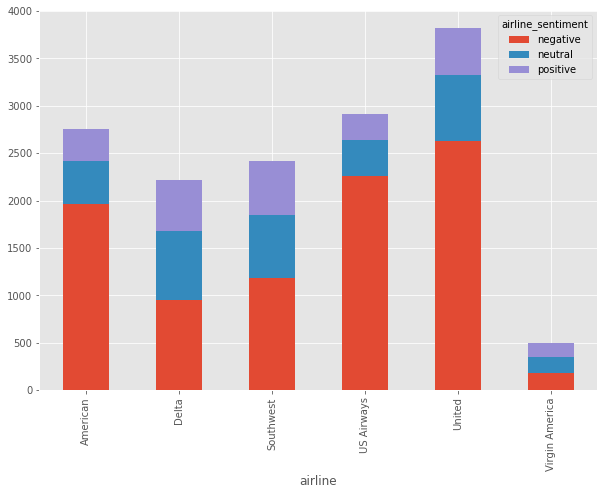

In [91]:
#Plot showing the tweet sentiments by airlines
pd.crosstab(train_orig.airline,train_orig.airline_sentiment).plot.bar(stacked=True, figsize=(10,7))

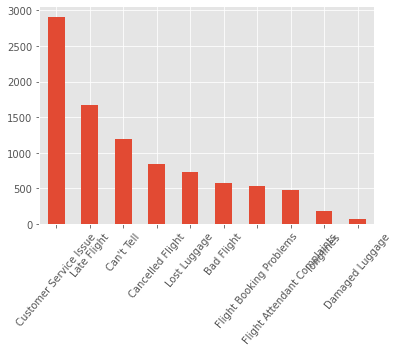

In [92]:
# Plot showing the top Negative tweet reasons
train_orig.negativereason.value_counts().plot.bar(rot=50)

Above shows missing data in the columns for negative reason, while customer service and flight delays are the the next top reasons for a negative experience

In [93]:
# Tail of the review text
train_orig['text'].tail()

14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, dtype: object

Target categories of the airline sentiments , 3 classes 

In [94]:
print("Tweet sentiments are:\n")
print("------------------------------------------")
for item in train_orig['airline_sentiment'].unique():
    print(item)

Tweet sentiments are:

------------------------------------------
neutral
positive
negative


In [95]:
train_orig.airline_sentiment.value_counts(normalize = True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

We see a biased dataset where the negative reviews compromises of 63% of the data 

In [0]:
# Cleaning the text and replacing the airline individual names by airline
train_orig['text'] = train_orig['text'].apply(clean_ascii)
train_orig['text'] = train_orig['text'].apply(text_replace)

In [97]:
# Picking up the required columns 
train = pd.concat([train_orig['airline_sentiment'], train_orig['text']], axis=1)
train.tail()

,airline_sentiment,text
14635,positive,@airline thank you we got on a different fligh...
14636,negative,@airline leaving over 20 minutes Late Flight. ...
14637,neutral,@airline Please bring American Airlines to #Bl...
14638,negative,"@airline you have my money, you change my flig..."
14639,neutral,@airline we have 8 ppl so we need 2 know how m...


In [98]:
# Creating the test and train data and text only data for language model 
train_orig.sort_index(inplace=True)
cutoff = int(0.1 * train_orig.shape[0])
train_orig[['airline_sentiment', 'text']][:cutoff].to_csv('Tweets_filtered_test.csv', index=False, encoding='utf-8')
train_orig[['airline_sentiment', 'text']][cutoff:].to_csv('Tweets_filtered_train.csv', index=False, encoding='utf-8')
train_orig[['text']][cutoff:].to_csv('Tweets_text_only_train.csv', index=False, encoding='utf-8')
print("Test Data ",train_orig[['airline_sentiment', 'text']][:cutoff].shape)
print("Train Data ",train_orig[['airline_sentiment', 'text']][cutoff:].shape)

Test Data  (1464, 2)
Train Data  (13176, 2)


In [99]:
# Train data
data = TextClasDataBunch.from_csv('.', 'Tweets_filtered_train.csv')
data.show_batch()

text,target
xxbos @airline xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @airline xxup poor xxup experience 2day at ord xxunk . 8 emp . w / 3 cust . 10 waiting . xxmaj asked to speak w / supervisor . xxmaj told 20 min . xxmaj in a mtg ! ! xxmaj what ? ! ? !,negative
xxbos @airline xxmaj took a flight yesterday fron xxup tpa - xxup dfw - xxup aus . xxmaj bag went to xxup iah . xxmaj today bag went to xxup iah - xxup dfw and then back to xxup iah . xxmaj still no bag !,negative
"xxbos @airline yes , i am as well . * * xxup five * * xxup hours xxup on xxup hold , xxup folks . xxmaj can you xxup please tell me if this is typical ? ! xxmaj trying to be understanding here .",negative
"xxbos @airline xxmaj united xxmaj club team is xxup a+ & & got me a seat xxmaj late xxmaj flightr . xxmaj still , not sure why a last min xxup ual xxmaj cancelled xxmaj flightlation costs me $ yet overbooked folks get $ ?",negative


In [100]:
# Preprocess keys
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '@airline']

Preprocessing the text by replacing the unknown, padding , repeated words, beginning of sentenses, uppercase etc..

In [101]:
# Preprocessed text reviews
print(data.train_ds[0][0])
print(data.train_ds[1][0])
print(data.train_ds[2][0])

xxbos @airline @danahajek : she means to say there has been so many complaints today ( this week , this month ) that she ca n't respond b / c she 's alone
xxbos @airline . i 'm delayed in xxmaj cha , will miss my connection in xxmaj charlotte for lga . xxmaj not good
xxbos @airline why would i bother wasting my time calling them when they are xxunk do nothing


# Modelling

idx,text
0,xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow xxbos @airline xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you xxbos @airline it was delivered ! xxmaj thank you for making sure it arrived at my xxunk ! xxbos @airline - rebooked
1,", xxup nj and i 'm going to xxup sfo xxbos @airline you a xxunk xxbos @airline xxmaj thanks ! xxmaj good to know . xxbos @airline okay . xxmaj thanks . xxbos @airline xxmaj conference xxunk in 3 hours . xxmaj up all night due to delays and still waiting to talk to someone about lost luggage . xxbos @airline xxmaj seat xxup xxunk , xxmaj flight xxup xxunk"
2,"to the plane . xxmaj get it together , folks . xxbos @airline xxup ua xxunk there is no way a plane "" loses its software "" i believe you decided to do an upgrade ... xxbos @airline already missed connection ... xxup ua xxunk xxbos @airline xxunk once you get the problem fixed - then the crew expires - and the delay turns into a xxmaj cancelled xxmaj flight"
3,"- xxup hou , told him my father is dying and needed to get my xxunk on the cabin . he did nothing # shameful xxbos @airline xxmaj any chance you are allowing reflight xxmaj booking xxmaj problems yet for travel out of xxmaj denver this weekend due to xxunk storm ? xxbos we all watched as the crew was xxunk from the back to 1st class . xxmaj xxunk"
4,"\n \n xxmaj except now he 's stuck on the runway in xxmaj houston . xxbos @airline thank you for getting our daughter home when @airline xxmaj cancelled xxmaj flightled all their flights to xxmaj nashville xxbos @airline thanks for the re - upgrade to 1st class . xxmaj it may be a 45 min flight , but it is appreciated . xxbos @airline makes total sense , except"


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


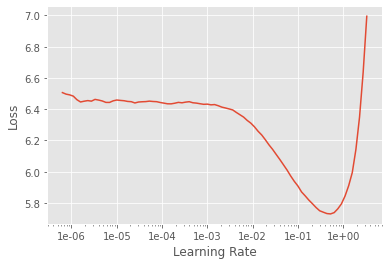

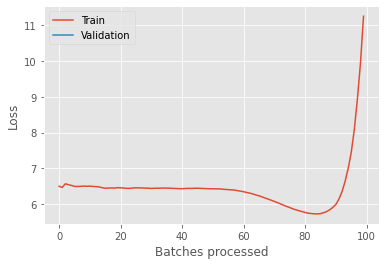

In [103]:
# Modelling with text only data for the Language Model
bs = 24
seed = 333

data_lm = (TextList.from_csv('.', 'Tweets_text_only_train.csv')
            .split_by_rand_pct(0.1, seed = seed)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

data_lm.show_batch()

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)


learn.lr_find()

learn.recorder.plot()
learn.recorder.plot_losses()

Building a language model using the training data tweets and pre trained model on wiki 103, created a learner object and train a bit.

In [104]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.009744,3.728323,0.296518,00:12


In [105]:
learn.show_results()


text,target,pred
"xxbos @airline stuck on xxmaj tarmac for 30 mins at xxup phl waiting for someone to load baggage , ridiculous",http : / / t.co / xxunk xxbos @airline i consider myself a loyal customer to the brand but i,# : / / t.co / xxunk xxbos @airline xxmaj 'm flying a xxunk customer . xxup customer . i
with an infant and a 4 year old ? xxmaj then customer service never answered the phone . i 've,"tried all night . xxbos @airline booked flight in sept to get best price for xxmaj april to usa ,",been to the . xxmaj @airline xxmaj a xxunk xxmaj of xxmaj a flight for my cancelled . be .
and 3 hour delay . xxmaj it really helped me xxunk xxunk for my afternoon meetings . xxmaj hello @airline,! xxbos @airline on a happy note our 719 crew is wonderful . xxmaj ca n't say enough great things,i xxmaj @airline xxmaj hold flight day . xxunk were were on . xxmaj we n't get anything to service
xxbos @airline been on hold for xxunk minutes and counting for a month old change fee refund request for a,funeral . xxmaj this is pathetic . xxbos @airline served the xxunk food i ve ever seen yesterday . xxmaj,xxunk . xxmaj no is the . xxbos @airline xxmaj on xxunk of for had been been . . xxmaj
xxmaj do n't xxunk xxunk and conditions . # xxunk xxbos @airline cool ! xxmaj are there xxunk at xxup,jfk ? i can walk short xxunk but not xxunk . xxbos @airline so i would have to go though,jfk ? xxbos 'm n't to and xxbos i xxunk . xxmaj @airline xxmaj i 'm like to wait to


In [106]:
learn.save('fit_1')
# learn.load('fit_1')
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.651816,3.621959,0.308869,00:12
1,3.524165,3.523085,0.324405,00:12
2,3.387244,3.460515,0.329970,00:12
3,3.187756,3.435150,0.333423,00:12
4,2.967079,3.464059,0.330387,00:12
5,2.735252,3.505493,0.331637,00:13
6,2.527335,3.564522,0.329732,00:12
7,2.364243,3.615654,0.327470,00:12
8,2.244776,3.646971,0.327411,00:12
9,2.194352,3.660262,0.326369,00:12


Training further

In [107]:
print(learn.show_results())

# Predict the language model 
print(learn.predict('My flight was great!', n_words=50))

# Predict the language model 
print(learn.predict('delayed flight', n_words=50))

text,target,pred
"xxbos @airline stuck on xxmaj tarmac for 30 mins at xxup phl waiting for someone to load baggage , ridiculous",http : / / t.co / xxunk xxbos @airline i consider myself a loyal customer to the brand but i,"that : / / t.co / xxunk xxbos @airline xxmaj 'm flying a "" customer . your customer . who"
with an infant and a 4 year old ? xxmaj then customer service never answered the phone . i 've,"tried all night . xxbos @airline booked flight in sept to get best price for xxmaj april to usa ,","been to day . xxbos @airline xxmaj a xxup 2 , be my customer but a flight xxunk be and"
and 3 hour delay . xxmaj it really helped me xxunk xxunk for my afternoon meetings . xxmaj hello @airline,! xxbos @airline on a happy note our 719 crew is wonderful . xxmaj ca n't say enough great things,xxbos xxbos @airline xxmaj hold flight trip . flight will member doing ! xxmaj we n't wait we delays people
xxbos @airline been on hold for xxunk minutes and counting for a month old change fee refund request for a,funeral . xxmaj this is pathetic . xxbos @airline served the xxunk food i ve ever seen yesterday . xxmaj,flight ? xxmaj help is ridiculous . xxbos @airline xxmaj me xxunk of xxunk paid served served in . xxmaj
xxmaj do n't xxunk xxunk and conditions . # xxunk xxbos @airline cool ! xxmaj are there xxunk at xxup,jfk ? i can walk short xxunk but not xxunk . xxbos @airline so i would have to go though,jfk or xxmaj 'm see to enough xxbos i get xxbos xxbos @airline xxmaj i 'm like to wait to


None
My flight was great! Thank you ! # worstcustomerservice xxbos @airline will u guys be responding to tweets when you will talk with million travelers ? http : / / t.co / T.co / : then xxbos @airline why do you call the number charged ? ! Where 's your computer
delayed flight to Dallas on Tuesday = Flight 700 to BWI . Going over the and then connecting lines for two hours . xxbos @airline Cool . UAL has the entire # TV on the phone with a companion service # and # magazine


In [0]:
learn.save('fit_2')
learn.save_encoder('fine_tuned_enc')

In [109]:
data_clas = (TextList.from_csv('.', 'Tweets_filtered_train.csv', cols = 'text')               
             .split_by_rand_pct(0.1, seed = seed)
             .label_from_df(cols=0)
             .databunch(bs=bs))
data_clas.save('data_clas.pkl')
data_clas.show_batch()

text,target
xxbos @airline xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @airline xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to xxunk it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
xxbos @airline xxmaj my xxmaj flight xxmaj booking xxmaj problems xxup xxunk just times out when i select it under xxmaj manage xxmaj my xxmaj flight xxmaj booking xxmaj problems for months now . i have emailed but no response . xxmaj help ?,negative
"xxbos @airline ( 2 / 2 ) xxmaj it xxunk that if ca n't confirm xxunk at time of xxmaj flight xxmaj booking xxmaj problems , i should assume that it may never clear . xxmaj did n't used to be that way",negative
xxbos @airline xxmaj missed xxup xxunk flight due to ur xxmaj cancelled xxmaj flightlation . xxmaj xxunk supervisor disgusting . xxmaj now day xxmaj late xxmaj flight . xxmaj no apology or upgrade offer to xxup lhr from xxup ord ? ? ?,negative


In [110]:
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 4040]           1,620,040  True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 1,620,040
Total trainable params: 1,620,040
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss func

In [111]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11859 items)
x: TextList
xxbos @airline the delay is due to customer service for 20 people ? xxmaj what about the xxup xxunk - xxup service you provided for 100 + ? # xxunk # xxunk,xxbos @airline he is so excellent and so reliable :) # happycustomer,xxbos @airline but again xxup united xxup xxunk xxup give 2 xxup xxunk xxup about xxup their xxup customers,xxbos @airline xxmaj she is travelling from xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow,xxbos @airline xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you
y: CategoryList
negative,positive,negative,neutral,neutral
Path: .;

Valid: LabelList (1317 items)
x: TextList
xxbos @airline stuck on xxmaj tarmac for 30 mins at xxup phl waiting for someone to load baggage , ridiculous http : / / t.co / xxunk,xxbos @airline i consider myself a loyal c

Learn the classification task on top of Language Model

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


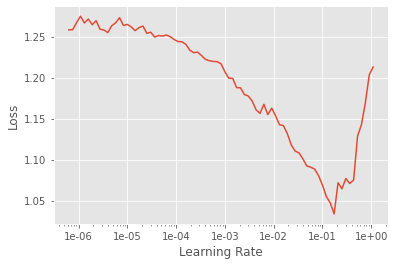

In [112]:
learn.lr_find()
learn.recorder.plot()

In [113]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.675870,0.546805,0.795748,00:15


In [0]:
learn.save('first')
# learn.load('first)

In [115]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.639342,0.501267,0.807897,00:16


Unfreezing and learning different layers




In [0]:
learn.save('second')
# learn.load('second')

In [117]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.576789,0.464930,0.818527,00:17


In [118]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.485958,0.453477,0.826120,00:16
1,0.436825,0.472240,0.802582,00:16
2,0.400810,0.456281,0.817008,00:17


In [119]:
learn.show_results()


text,target,prediction
xxbos @airline xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,negative,negative
xxbos @airline xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup xxunk up here this xxup am .. so i understand .. xxmaj btw xxup xxunk is my xxmaj airline when i m able to xxunk .. xxmaj love you guys . : ),positive,positive
"xxbos @airline xxmaj united xxmaj club team is xxup a+ & & got me a seat xxmaj late xxmaj flightr . xxmaj still , not sure why a last min xxup ual xxmaj cancelled xxmaj flightlation costs me $ yet overbooked folks get $ ?",negative,negative
xxbos @airline xxmaj in car xxunk to xxup dfw . xxmaj pulled over 1hr ago - very icy roads . xxmaj on - hold with xxup aa since 1hr . xxmaj ca n't reach xxunk for xxup xxunk . xxmaj xxunk 2 do ?,negative,negative
"xxbos @airline my wife was on a flt from xxup bro to xxup xxunk via xxup dfw that was xxmaj cancelled xxmaj flighted . xxmaj bought an xxup swa flight to get her home . xxmaj xxunk refund , xxup dm me plz ?",negative,negative


# Testing the results

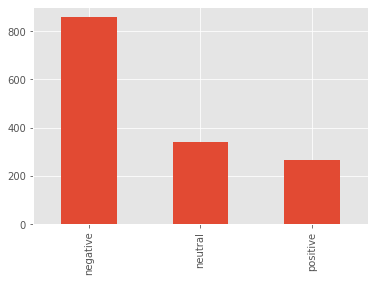

In [120]:
# Loading the test dataset
test_df = pd.read_csv("Tweets_filtered_test.csv", encoding="utf-8")
test_df['airline_sentiment'].value_counts().plot(kind='bar')

In [121]:
#predicting the test dataset sentiments and calculating the overall accuracy
test_df['pred_sentiment'] = test_df['text'].apply(lambda row: str(learn.predict(row)[0]))
print("Test Accuracy: ", accuracy_score(test_df['airline_sentiment'], test_df['pred_sentiment']))

Test Accuracy:  0.8019125683060109


In [122]:
# Confusion matrix of the prediction & actual categories
pd.crosstab(test_df['pred_sentiment'], test_df['airline_sentiment'])


airline_sentiment,negative,neutral,positive
pred_sentiment,,,
negative,792,107,56
neutral,49,204,32
positive,18,28,178


In [123]:
# Classification report of each of the target classes wrt to the test dataset
from sklearn.metrics import classification_report
print(classification_report(test_df['pred_sentiment'], test_df['airline_sentiment'], digits=2))

              precision    recall  f1-score   support

    negative       0.92      0.83      0.87       955
     neutral       0.60      0.72      0.65       285
    positive       0.67      0.79      0.73       224

    accuracy                           0.80      1464
   macro avg       0.73      0.78      0.75      1464
weighted avg       0.82      0.80      0.81      1464



we see a F1 score of 88% for negative reviews, 67% for neutral and 73% for the positive reviews. An overall accuracy of 81 %.

In [124]:
# Wrongly predicted tweets
test_df[test_df.pred_sentiment != test_df.airline_sentiment]

,airline_sentiment,text,pred_sentiment
1,positive,@airline plus you've added commercials to the ...,negative
2,neutral,@airline I didn't today... Must mean I need to...,negative
6,positive,"@airline yes, nearly every time I fly VX this ...",negative
7,neutral,@airline Really missed a prime opportunity for...,negative
8,positive,"@airline Well, I didn'tbut NOW I DO! :-D",neutral
...,...,...,...
1431,neutral,@airline I just booked a flight for (2). When ...,negative
1436,negative,@airline i need help but in spanish,neutral
1438,negative,@airline I lost my sunglasses on the flight fr...,neutral
1439,neutral,@airline @reccewife with the exception of ever...,negative


In [125]:
print(learn.predict('My flight was delayed'))
print(learn.predict('messy flight'))
print(learn.predict('cleaned often still'))
print(learn.predict('cleaned often but'))
print(learn.predict('cleaned not so often'))

(Category negative, tensor(0), tensor([0.9403, 0.0275, 0.0322]))
(Category neutral, tensor(1), tensor([0.2172, 0.7529, 0.0299]))
(Category negative, tensor(0), tensor([0.7668, 0.1724, 0.0608]))
(Category negative, tensor(0), tensor([0.6452, 0.3227, 0.0321]))
(Category negative, tensor(0), tensor([0.9022, 0.0807, 0.0171]))


Predicting test reviews, we see that certain specific words change the sentiment though the percent by which the difference is there is not too much 